$$
\large \textbf{Problema 01}
$$

Se tiene una placa cuadrada de aluminio cuyos bordes están en las condiciones que se indican en la figura: tres lados a temperaturas fijas y otro, el inferior, aislado térmicamente (flujo de calor igual a cero). Encuentre, utilizando el método de diferencias finitas, los valores de temperatura y flujo de calor para cada punto. Utilice primero la grilla señalada y luego generalice el problema a un número variable de nodos en cada eje de coordenadas. Haga un estudio del tiempo de cálculo en función del tamaño del sistema.
<center><img src="ImgProb01.png"></center>

***

In [1]:
import numpy as np                # Librería de álgebra lineal
import matplotlib.pyplot as plt   # Librería de gráficos
plt.rc('figure', figsize=(15,8))
plt.rc('font', size=16)
import time

La ecuación diferencial que rige el problema es la ecuación de Poison, que es la ecuación de transferencia térmica homogénea:

$$
\frac{\partial^2 T_{(x,y)}}{\partial x^2}+\frac{\partial^2 T_{(x,y)}}{\partial y^2}=0
$$

Debido a que los contornos del recinto donde debemos resolver la ecuación de Poison son los adecuados, se utiliza el método de diferencias finitas.

### Datos del problema
La chapa tiene $N=N_xN_y$ nodos y las condiciones de contorno dadas por el problema.

In [2]:
Nx = 100
Ny = 100
N = Nx*Ny

TA = 75
TB = 0
TC = 50
TD = 100

Es conveniente que la numeración de los nodos sea en función de un único índice $k$, de modo que las temperaturas puedan representarse en un vector $\bar{T} = \left( T_1,\:T_2,\:\cdots,\:T_N \right)$. Contando de izquierda a derecha y de abajo a arriba, los vértices son:

- Inferior izquierdo: $k=0$

- Inferior derecho:   $k=N_x-1$
- Superior derecho:   $k=N-1$
- Superior izquierdo: $k=N-N_x$

### Matricialización
Según el método de diferencias fnitas, deben usarse las versiones discretas de las derivadas segundas en la ecuación de Poison:

$$
\left. \frac{\partial^2 T}{\partial x^2} \right|_k = \frac{T_{k+1}-2\:T_k+T_{k-1}}{\Delta x^2}
\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:;\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:
\left. \frac{\partial^2 T}{\partial y^2} \right|_k = \frac{T_{k+N_x}-2\:T_k+T_{k-N_y}}{\Delta y^2}
$$

de modo que, para el conjunto de nodos del interior de la chapa:

$$
\frac{T_{k+1}-2\:T_k+T_{k-1}}{\Delta x^2} + \frac{T_{k+N_x}-2\:T_k+T_{k-N_x}}{\Delta y^2} = 0
$$

$$
\beta^2\:T_{k-N_x} + T_{k-1} - 2\:(1+\beta^2)\:T_k + T_{k+1} + \beta^2\:T_{k+N_x} = 0
$$

donde se ha definido $\beta = \frac{\Delta x}{\Delta y}$.

Para los nodos de los bordes se toman las condiciones de contorno dadas por el problema y, dado que los vértices perteneces a 2 bordes cada uno, se toma el promedio entre las condiciones de contorno de cada borde.

In [3]:
class chapa:

    def __init__(self, Nx=3, Ny=3):
        self.Nx = Nx
        self.Ny = Ny
        self.N = Nx*Ny
        self.beta = Nx/Ny

    def makematrix(self, TA, TB, TC, TD): #CC, TipoCC
        Nx = self.Nx
        Ny = self.Ny
        N = self.N
        beta = self.beta
        M = np.eye(N)
        b = np.zeros([N, 1])
        for k in range(N):
            if k==0:                     # Vértice inf. izq. (A-B)
                b[k] = (TA+TB)/2
            elif k==Nx-1:                # Vértice inf. der. (B-C)
                b[k] = (TC+TB)/2
            elif k==N-1:                 # Vértice sup. der. (C-D)
                b[k] = (TD+TC)/2
            elif k==N-Nx:                # Vértice sup. izq. (D-A)
                b[k] = (TA+TD)/2
            elif k%Nx==0:                # Borde izq. (A)
                b[k] = TA
            elif k<Nx-1:                 # Borde inf. (B)
                b[k] = TB
            elif (k+1)%Nx==0:            # Borde der. (C)
                b[k] = TC
            elif k>Nx*(Ny-1)-1:          # Borde sup. (D)
                b[k] = TD
            else:                        # Nodos internos
                M[k,k] = -2*(1+beta**2)
                M[k,k-1] = 1
                M[k,k+1] = 1
                M[k,k-Nx] = beta**2
                M[k,k+Nx] = beta**2
        self.M = M
        self.b = b
        return M, b

In [4]:
Chapa = chapa(Nx, Ny)
M, b = Chapa.makematrix(TA, TB, TC, TD)

## Solución

In [5]:
T = np.linalg.solve(M, b)
T_matriz = T.reshape(Nx, Ny)
T_matriz = T_matriz[::-1]

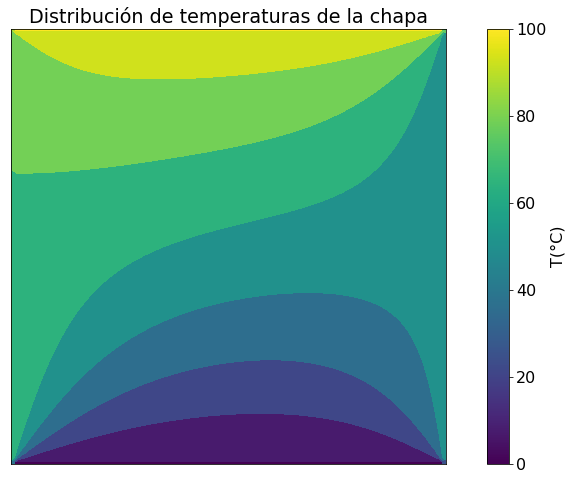

In [6]:
mapable = plt.imshow(T_matriz)
plt.contourf(T_matriz)
cbar = plt.colorbar(mapable)
cbar.set_label('T(°C)')
plt.title('Distribución de temperaturas de la chapa')
plt.xticks([])
plt.yticks([])
plt.show()

### Estudio del tiempo de cálculo